In [8]:
import datetime
import os
import io
import psycopg2
import numpy as np
from psycopg2.extensions import register_adapter, AsIs
import geoalchemy2
import ssl
from shapely.geometry import Point, Polygon
import pandas as pd
import geopandas as gdp
import numpy as np
import pygeos

from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# settings to display all columns
pd.set_option("display.max_columns", None)

import gcp_postgresql

In [9]:
data_path = '../data/bw/'

df = pd.DataFrame()

for f in os.listdir(data_path):
    
    df = pd.concat([df, pd.read_csv(data_path + f)])
    
df.drop(columns=[i for i in df.columns if i[:7] == 'Unnamed'], inplace=True)
    
cols = ['Date', 'GIS Latitude', 'GIS Longitude', 'Reef Zone', 'Cloud Cover', 'Bleaching?', '% bleached', 'Notes']    

df = df[cols]

df.columns = ['bw_date', 'bw_lat', 'bw_lon', 'reef_zone', 'cloud_cover', 'bleaching', 'bleaching_sev', 'notes']

df['bleaching'] = df.bleaching.str.lower()

df = df.dropna(subset=['bleaching'])

df = df[df.bleaching != ' '].reset_index(drop=True)

df.tail()

,bw_date,bw_lat,bw_lon,reef_zone,cloud_cover,bleaching,bleaching_sev,notes
2205,10/16/2020,24.53029,-81.60839,NaN,Not Provided,yes,1-10%,No comments
2206,10/16/2020,24.53712,-81.59362,NaN,Not Provided,yes,1-10%,No comments
2207,10/16/2020,24.55061,-81.5743,NaN,Not Provided,yes,1-10%,No comments
2208,10/16/2020,24.57965,-81.5639,NaN,Not Provided,yes,1-10%,No comments
2209,10/16/2020,24.45188,-81.87779,NaN,Not Provided,no,0%,No comments


In [10]:
df.to_csv('florida_bw_2014_2020.csv', index=False)

In [11]:
df = pd.read_csv('florida_bw_2014_2020.csv')
df

,bw_date,bw_lat,bw_lon,reef_zone,cloud_cover,bleaching,bleaching_sev,notes
0,5/30/2014,24.72505,-80.91887,patch reef,clear,no,0%,NaN
1,5/30/2014,24.71283,-80.94525,patch reef,clear,no,0%,purple blotch on Ssid
2,5/30/2014,24.73237,-80.90117,patch reef,clear,no,0%,purple blotch on Ssid; lots of Lionfish!
3,5/30/2014,24.62232,-81.36407,patch reef,partly cloudy,no,0%,NaN
4,5/31/2014,24.52512,-81.51948,patch reef,partly cloudy,no,0%,Corals knocked over from fast currents and wav...
...,...,...,...,...,...,...,...,...
2205,10/16/2020,24.53029,-81.60839,NaN,Not Provided,yes,1-10%,No comments
2206,10/16/2020,24.53712,-81.59362,NaN,Not Provided,yes,1-10%,No comments
2207,10/16/2020,24.55061,-81.57430,NaN,Not Provided,yes,1-10%,No comments
2208,10/16/2020,24.57965,-81.56390,NaN,Not Provided,yes,1-10%,No comments


Text(0.5, 1.0, 'Bleaching Events')

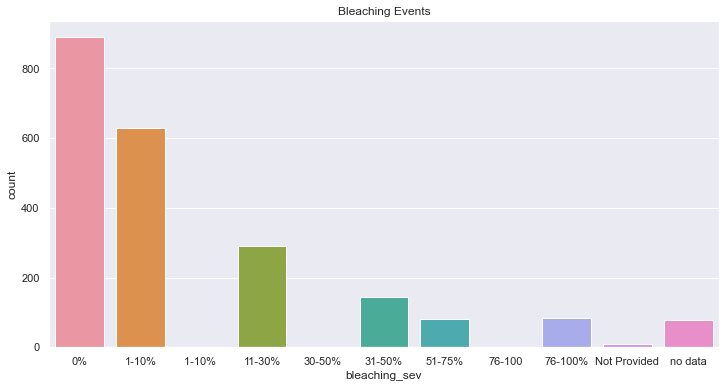

In [29]:
bleach_cnt = df.groupby('bleaching_sev').bw_date.count().reset_index()
bleach_cnt.rename(columns={'bw_date':'count'}, inplace=True)

fig = plt.figure(figsize=(12,6))

sns.barplot(x='bleaching_sev', y='count', data=bleach_cnt)
plt.title('Bleaching Events')

Text(0.5, 1.0, 'Bleaching Events')

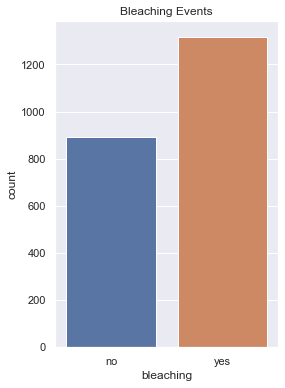

In [13]:
df[['bw_lat', 'bw_lon']].drop_duplicates()

,bw_lat,bw_lon
0,24.72505,-80.91887
1,24.71283,-80.94525
2,24.73237,-80.90117
3,24.62232,-81.36407
4,24.52512,-81.51948
...,...,...
2205,24.53029,-81.60839
2206,24.53712,-81.59362
2207,24.55061,-81.57430
2208,24.57965,-81.56390
